# Notebook for training normalizing flow to learn 2D xy distribution

#### Imports
Make sure to install normalizing-flows with pip

In [1]:
from datetime import date
date = date.today().strftime("%b_%d")

# Import packages
import torch
import numpy as np
import normflows as nf
import pandas as pd
import uproot as up

from matplotlib import pyplot as plot
import math
import time
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)

#### We want to use a GPU

In [2]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Need to open the csv and convert values to float32 to work with model

csv can be downloaded from here: https://duke.box.com/s/8olajv4k19cnu64l30nxrydhpfbn8vn7

In [3]:
df = pd.read_csv("neutron_calorimeter_data.csv")
input_tensor = torch.from_numpy(df.values).to(torch.float32)

In [4]:
indexes = torch.randperm(input_tensor.shape[0]) #shuffle data
dataset = input_tensor[indexes] / 1000 #normalize

In [5]:
train_frac = 0.8
test_frac = 0.1
val_frac = 0.1
train_lim = int(np.floor(dataset.shape[0] * train_frac))
test_lim = train_lim + int(np.floor(dataset.shape[0] * test_frac))
val_lim = test_lim + int(np.floor(dataset.shape[0] * val_frac))
train_data = dataset[:train_lim]
test_data = dataset[train_lim:test_lim]
val_data = dataset[test_lim:val_lim]

#### Plot the inputs to see our target

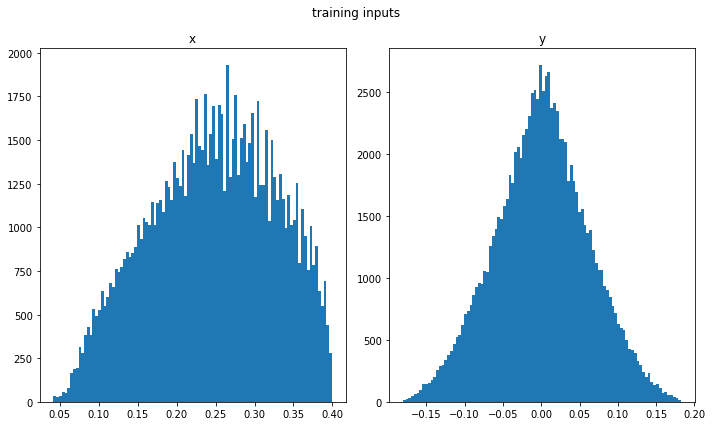

In [6]:
input_fig, input_axs = plot.subplots(1,2,figsize=(10,6))
input_fig.suptitle("training inputs")
input_axs[0].hist(train_data[:100000,0],bins = 100)
input_axs[0].set_title("x")
input_axs[1].hist(train_data[:100000,1],bins = 100)
input_axs[1].set_title("y")
input_fig.tight_layout()

#### Here we define the flow architecture

In [11]:
run_num = 1 #to keep track of different configs

num_layers = 48 #number of flow layers
hidden_units = 64 #hidden dimension
batch_size = 128
lr = 1e-5
num_epochs = 8

latent_size = 2 #dimension of distribution

#strings for file paths
lr_str = str(lr)
hidden_units_str = str(hidden_units)
num_layers_str = str(num_layers)
batch_size_str = str(batch_size)
run_num_str = str(run_num)

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, hidden_units, hidden_units, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.NormalizingFlow(base, flows)

# Move model on GPU if available
model = model.to(device)

#### Can be helpful to create directories for the data and plots

In [12]:
import datetime

x = datetime.datetime.now()
today = x.strftime("%B_%d")

model_path = "models/" + today + "/"
checkdir(model_path)

loss_path = "plots/loss/" + today + "/"
checkdir(loss_path)

run_info = "run_" + run_num_str+ "_"+ num_layers_str + "flows_" + num_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs"

In [ ]:
# Train model
max_iter = int(np.floor(train_data.shape[0] / batch_size))
train_loss_hist = np.array([])
val_loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

validation_frequency = 100  # Perform validation every 100 training steps
print("beginning training loop")
global_step = 0
for epoch in range(num_epochs):
    print(f"Beginning epoch #{epoch}")
    model.train()  # Set model to training mode
    for it in range(max_iter):
        optimizer.zero_grad()
        # Get training samples
        begin = it * batch_size
        end = (it + 1) * batch_size
        samples = train_data[begin:end].to(device)
        # Compute loss
        loss = model.forward_kld(samples)
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        # Log loss
        train_loss_hist = np.append(train_loss_hist, loss.to('cpu').data.numpy())

        global_step += 1

        # Validation step every 100 training steps
        if global_step % validation_frequency == 0:
            model.eval()  # Set model to evaluation mode
            val_loss = 0
            val_iter = min(100, int(np.floor(val_data.shape[0] / batch_size)))  # Limit validation to 100 batches
            with torch.no_grad():
                for val_it in range(val_iter):
                    begin = val_it * batch_size
                    end = (val_it + 1) * batch_size
                    samples = val_data[begin:end].to(device)
                    loss = model.forward_kld(samples)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / val_iter
            val_loss_hist = np.append(val_loss_hist, avg_val_loss)
            
#             print(f"Step {global_step} - Train Loss: {train_loss_hist[-1]:.4f}, Val Loss: {avg_val_loss:.4f}")
            
            model.train()  # Set model back to training mode
    model.save(model_path + run_info + f"_checkpoint_e{epoch}.pth")
    print(f"Epoch {epoch} completed.")

In [ ]:
model.save(model_path + run_info + ".pth")
# Plot loss
plot.figure(figsize=(5, 5))
plot.scatter(range(len(train_loss_hist)),train_loss_hist, np.ones(len(train_loss_hist)) * 0.2, label='loss', alpha = 1)
plot.scatter(np.linspace(0,len(train_loss_hist),len(val_loss_hist)),val_loss_hist, np.ones(len(val_loss_hist)) * 1, label='loss', alpha = 1)
# plot.xlim(10000,11000)
plot.legend()
plot.savefig( loss_path + run_info + ".jpeg")

## Inference

Skip here if you want to use pretrained model

In [19]:
run_num = 1 #to keep track of different configs

num_layers = 48 #number of flow layers
hidden_units = 64 #hidden dimension
batch_size = 128
lr = 1e-5
num_epochs = 8

latent_size = 2 #dimension of distribution

#strings for file paths
lr_str = str(lr)
hidden_units_str = str(hidden_units)
num_layers_str = str(num_layers)
batch_size_str = str(batch_size)
run_num_str = str(run_num)

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, hidden_units, hidden_units, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.NormalizingFlow(base, flows)

# Move model on GPU if available
model = model.to(device)
#load in the pre-trained model
model.load("models/November_04/run_1_2flows_48hl_64hu_128bs.pth")

In [20]:
num_samples = 20000
batch_size = 1000
it = 0
num_batches = int(num_samples / batch_size)

In [21]:
begin_time = time.time()
samples = []
#We can sample any number of samples here, they are all independent of one another
with torch.no_grad():
    for it in range(num_batches):
        batch_samples = model.sample(num_samples=batch_size)[0].cpu()
        samples.append(batch_samples)

samples = torch.cat(samples, dim=0)
end_time = time.time()
print(f"sampling took {end_time - begin_time} seconds")

sampling took 0.32965087890625 seconds


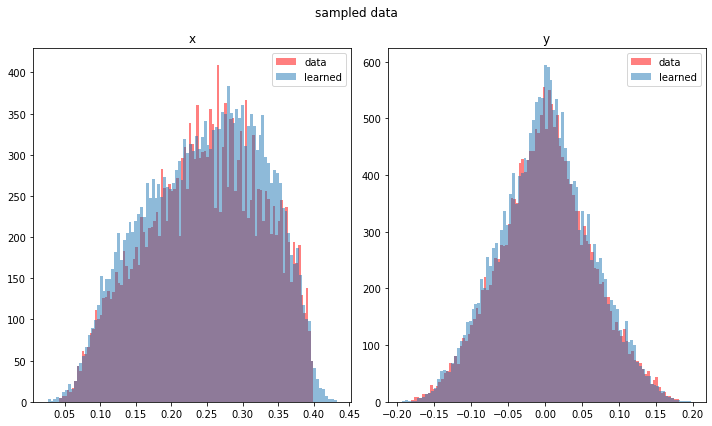

In [22]:
x_valid_samples = samples[:,0]
y_valid_samples = samples[:,1]

sample_fig, sample_axs = plot.subplots(1,2,figsize=(10,6))
sample_fig.suptitle("sampled data")
sample_axs[0].hist(train_data[:len(x_valid_samples),0],bins = 100,color = "r", alpha = 0.5,label = "data")
sample_axs[0].hist(x_valid_samples,bins = 100, alpha = 0.5,label = "learned")
sample_axs[0].set_title("x")
sample_axs[0].legend()
sample_axs[1].hist(train_data[:len(y_valid_samples),1],bins = 100,color = "r", alpha = 0.5,label = "data")
sample_axs[1].hist(y_valid_samples,bins = 100,alpha = 0.5,label = "learned")
sample_axs[1].set_title("y")
sample_axs[1].legend()
sample_fig.tight_layout()
sample_fig.savefig("plots/test/test.jpeg")